
# Ollama + Jupyter Guide

Welcome! This tutorial walks you through how to connect a Jupyter notebook to an **Ollama server**, enabling you to run large language models locally — similar to interacting with the OpenAI API, but **without the cost**.

# 🚀 Launching the Ollama Server on Yens GPU Cluster

Before you can send any prompts or run inference, you need to start the Ollama server.


📖  Refer to this [RCpedia blog post](https://rcpedia.stanford.edu/blog/2025/05/12/running-ollama-on-stanford-computing-clusters/) to launch your very own server!
<br>


In [40]:
import requests # This is for communicating with the HTTP server
import json # This is for formatting the requests and returns
import os
import pwd
from IPython.display import display, Markdown, JSON

ollama_url = None

def get_scratch_base_simple():
    """Get SCRATCH_BASE path by auto-detecting group name from home directory"""
    # First try to get from environment variable
    if 'SCRATCH_BASE' in os.environ:
        return os.environ['SCRATCH_BASE']
    
    # Auto-detect group name from home directory path
    try:
        home_dir = pwd.getpwuid(os.getuid()).pw_dir
        path_parts = home_dir.split('/')
        
        # Look for group name after 'mnt' in path like /mnt/GROUP_NAME/home/username
        if 'mnt' in path_parts:
            mnt_index = path_parts.index('mnt')
            if mnt_index + 1 < len(path_parts):
                group_name = path_parts[mnt_index + 1]
                username = os.environ.get('USER', os.getlogin())
                return f"/mnt/{group_name}/home/{username}"
    except:
        pass
    
    return f"/mnt/REPACSS/home/{os.environ['USER']}"

SCRATCH_BASE = get_scratch_base_simple()
# Attempt to read the host and port from scratch folder
try:
    with open(f"{SCRATCH_BASE}/ollama/host.txt") as f:
        HOST = f.read().strip()
    with open(f"{SCRATCH_BASE}/ollama/port.txt") as f:
        PORT = f.read().strip()
    ollama_url = f"http://{HOST}:{PORT}"
except Exception as e:
    print("[⚠️] Could not read host/port from scratch. If using someone else's server, manually set the `ollama_url` below.")
    # You can optionally provide a fallback manually here
    # ollama_url = 'http://HOST:PORT'  # Uncomment and modify if needed

# If no URL is available, raise an exception or pause
if ollama_url is None:
    raise ValueError("No Ollama server URL available. Please set `ollama_url` manually and run cell again")

# Parse server and port from the URL
server = ':'.join(ollama_url.split(':')[0:2])
port = ollama_url.split(':')[-1]

# Display interaction information
display(Markdown(f"""
# How can we interact with this server?

Once the server is running, you can interact with it by sending HTTP requests to its URL.

The server is running on **{server}**, and you need to contact it through port **{port}**.
"""))


# How can we interact with this server?

Once the server is running, you can interact with it by sending HTTP requests to its URL.

The server is running on **http://rpg-93-7**, and you need to contact it through port **53442**.


## Quick Start

In [41]:
import requests
import json

# Use your existing ollama_url
# ollama_url should already be set from your previous code

def chat_with_ollama(message, model="llama3.1:8b"):
    """Send message to ollama and get response"""
    try:
        response = requests.post(
            f"{ollama_url}/api/chat",
            json={
                "model": model,
                "messages": [
                    {"role": "user", "content": message}
                ],
                "stream": False
            }
        )
        
        if response.status_code == 200:
            result = response.json()
            return result["message"]["content"]
        else:
            return f"Error: HTTP {response.status_code}"
            
    except Exception as e:
        return f"Connection error: {e}"

# Simple interactive function
def start_chat(model="llama3.1:8b"):
    """Start continuous chat with the model"""
    print(f"🤖 Starting chat with {model}")
    print("💡 Type 'quit', 'exit' or 'q' to end the conversation")
    print("=" * 50)
    
    while True:
        # Get user input
        user_input = input("\n👤 You: ").strip()
        
        # Check exit conditions
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("👋 Goodbye!")
            break
            
        if not user_input:
            continue
            
        # Get AI response
        print("🤖 AI: ", end="", flush=True)
        response = chat_with_ollama(user_input, model)
        print(response)

# Usage:
print("🚀 Ollama chat client is ready!")
print(f"🌐 Server URL: {ollama_url}")

# Start chatting
start_chat()

🚀 Ollama chat client is ready!
🌐 Server URL: http://rpg-93-7:53442
🤖 Starting chat with llama3.1:8b
💡 Type 'quit', 'exit' or 'q' to end the conversation



👤 You:  what is the capital of Texas


🤖 AI: The capital of Texas is Austin.



👤 You:  Introduce TTU


🤖 AI: TTU can refer to several things, but I'll cover a few possible interpretations:

1. **Texas Tech University**: Texas Tech University (TTU) is a public research university located in Lubbock, Texas, USA. It was founded in 1923 and has since grown to become one of the largest universities in the state of Texas.
2. **Tennessee Technological University**: Tennessee Technological University (TTU), also known as TTU or Tech, is a public university located in Cookeville, Tennessee, USA. It was established in 1915 and offers a range of undergraduate and graduate degree programs.
3. **Tallinn Technical University**: Tallinn Technical University (TTU) is a university located in Tallinn, Estonia. It's one of the largest technical universities in the Baltic countries.

In general, TTU can refer to any institution or organization that uses "TTU" as its abbreviation or acronym. If you could provide more context or specify which TTU you're interested in, I'd be happy to provide more information


👤 You:  who is the champion of PL 2024-2025?


🤖 AI: I don't have any information about the future, including the Champion of Premier League (PL) for season 2024-2025. My training data only goes up to a certain point in time and I do not have the ability to predict the future.

However, I can suggest checking official Premier League websites or sports news outlets for updates on the latest season's standings and champions when that information becomes available.



👤 You:  quit


👋 Goodbye!


# Analysis of the Codes

#### Check if server is running

In [2]:
try:
    r = requests.get(ollama_url)
    r.raise_for_status()
    print("✅ Success:", r.text)
except requests.exceptions.RequestException as e:
    print("❌ Failed to connect:", e)

✅ Success: Ollama is running


#### Preload model onto GPU

In [3]:
# Define the endpoint and payload
LLM_API_URL = f"{ollama_url}/api/chat"  # Could also be /api/generate
payload = {
    "model": "llama3.1:8b",
    "keep_alive": -1  # Keeps model loaded after request
}
headers = {"Content-Type": "application/json"}

# Send POST request
response = requests.post(LLM_API_URL, headers=headers, data=json.dumps(payload))
print(response.text)

{"model":"llama3.1:8b","created_at":"2025-08-08T14:18:36.211727388Z","message":{"role":"assistant","content":""},"done_reason":"load","done":true}


# Data Analysis Question

## Example: Can a LLM tell me how funny a joke is?

In [24]:
jokes = [
    '''What kind of shoes to frogs wear? Open-toad sandals.''',
    '''I just built an ATM that only gives out coins. I don’t know why no one’s thought of it before: it just makes cents!''',
    '''Did I ever tell you about the time I went mushroom foraging? It’s a story with a morel at the end.''',
    '''What happened when two slices of bread went on a date? It was loaf at first sight.''',
    '''Why do crabs never volunteer? Because they're shell-fish.''',
    '''I had a quiet game of tennis today. There was no racket.''',
    '''What's a shark's favorite saying? "Man overboard!"''',
    '''What did one slice of bread say to the other before the race? You're toast!''',
    '''I poured some water over a duck's back yesterday. I don't think he cared.''',
    '''I'm such a good navigator, a self-driving car once asked me for directions.''',
    '''Why do melons have weddings? They cantelope.''',
    '''What did the bison say to his son when he left the ranch? Bi-son.''',
    '''Watch what you say around the egg whites. They can't take a yolk.''',
    '''I'm so good at fixing things, my motto is, "If it is broke, I'll still fix it."''',
    '''Were did the pumpkins have their meeting? In the gourdroom.''',
    '''What's the best way to save your dad jokes? In a dadda-base.''',
    '''I got a new pen that can write under water. It can write other words too.''',
    '''My boss said “dress for the job you want, not for the job you have.” So I went in as Batman.''',
    '''I went to the aquarium this weekend, but I didn’t stay long. There’s something fishy about that place.''',
    '''Why can't dinosaurs clap their hands? Because they're extinct.''',
    '''I gave my handyman a to-do list, but he only did jobs 1, 3, and 5. Turns out he only does odd jobs.''',
    '''The Company may use derivative instruments to partially offset its business exposure to foreign exchange and interest rate risk. However, the Company may choose not to hedge certain exposures for a variety of reasons''',
    '''We are exposed to financial market risks, including changes in interest rates and currency exchange rates. To mitigate these risks, we may utilize derivative financial instruments, among other strategies. We do not use derivative financial instruments for speculative purposes.''',
    '''Check the appropriate box to designate whether you are a cat:
o	I am a cat.
x	I am not a cat.
 ''']


### 🔧 Sending a Request to the Ollama Chat API


##### 1. **Header** – Defines the format and type of the request and response

```json
{
  "Content-Type": "application/json"
}
```


##### 2. **URL** – The address to which you are sending the request
`http://HOST:PORT/api/chat` <br>
>**Format:** http://{OLLAMA_SERVER_URL}:{PORT}/api/{ENDPOINT}<br>
##### 3. **Payload** – The body of the request
This depends on the endpoint being used. For the `/api/chat` endpoint, the payload typically looks like:
``` json
{
    "model": "llama3.1:8b",  # Specify the model to use
    "messages": [
        {"role": "system", "content": system_prompt}, #System prompt for chat template
        {"role": "user", "content": user_prompt}
    ],
    "stream": False #Return it all at one time
}

```

#### System Prompt Declaration

The system prompt in a large language model (LLM) sets the initial behavior and tone of the model by defining its role, goals, and constraints before any user input is given. It acts as an invisible instruction that shapes all future responses by providing context, personality, and rules for how the model should act.

In [25]:
system_prompt = '''
You are HumorCritic-v1, an impartial humor analyst.  
Goal: For every joke you receive, produce (a) a *structured rating* of funniness on a 1–5 scale and (b) a short justification grounded in clear criteria.
{
  "overall_rating": <int 1–5>,
  "explanation": "word rationale explaining the why the joke got the overall rating it got"
}
If the input is not a joke or is too ambiguous, set score to 0 and explain.
'''
print(system_prompt)


You are HumorCritic-v1, an impartial humor analyst.  
Goal: For every joke you receive, produce (a) a *structured rating* of funniness on a 1–5 scale and (b) a short justification grounded in clear criteria.
{
  "overall_rating": <int 1–5>,
  "explanation": "word rationale explaining the why the joke got the overall rating it got"
}
If the input is not a joke or is too ambiguous, set score to 0 and explain.



#### User prompt Declaration

The user prompt is the explicit input or question given to the LLM by the user. It tells the model what task to perform or information to generate, serving as the main instruction the model responds to in context.

In [26]:
user_prompt = f'''
Joke to Analyze:
{jokes[0]}
'''
print(user_prompt)


Joke to Analyze:
What kind of shoes to frogs wear? Open-toad sandals.



In [27]:
# Define the chat endpoint URL
LLM_API_URL = f"{ollama_url}/api/chat"

# Define request headers
headers = {
    "Content-Type": "application/json"
}

# Construct the payload for the chat request
payload = {
    "model": "llama3.1:8b",
    "messages": [
        {"role": "system", "content": system_prompt},  # System instructions to guide the model
        {"role": "user", "content": user_prompt}       # User input to be processed
    ],
    "stream": False  # Set to True for streamed responses
}

# Display the request configuration
print("[INFO] Chat API Request Configuration")
print("URL:     ", LLM_API_URL)
print("Headers: ", headers)
print("Payload: ", payload)

[INFO] Chat API Request Configuration
URL:      http://rpg-93-7:53442/api/chat
Headers:  {'Content-Type': 'application/json'}
Payload:  {'model': 'llama3.1:8b', 'messages': [{'role': 'system', 'content': '\nYou are HumorCritic-v1, an impartial humor analyst.  \nGoal: For every joke you receive, produce (a) a *structured rating* of funniness on a 1–5 scale and (b) a short justification grounded in clear criteria.\n{\n  "overall_rating": <int 1–5>,\n  "explanation": "word rationale explaining the why the joke got the overall rating it got"\n}\nIf the input is not a joke or is too ambiguous, set score to 0 and explain.\n'}, {'role': 'user', 'content': '\nJoke to Analyze:\nWhat kind of shoes to frogs wear? Open-toad sandals.\n'}], 'stream': False}


In [28]:
response=requests.post(LLM_API_URL,headers=headers,data=json.dumps(payload))
print(response.json()['message']['content'])

**Joke Analysis**

* "overall_rating": 4
* "explanation": The joke's overall rating of 4 is due to its clever play on words, using the phrase "open-toed" in a punny way. This type of wordplay creates a unexpected twist on the typical meaning of the phrase, which contributes to the joke's humor. However, it doesn't quite reach a perfect score (5) because while the punchline is clear and quick-witted, it may not elicit an intense or prolonged laughter from most audiences.


## All Data

In [29]:
import json
import requests
import re

# System prompt that instructs the model to return JSON format
system_prompt = """You are a joke rating expert. Rate each joke on a scale of 0-5 where:
- 0: Not funny at all
- 1: Slightly amusing
- 2: Mildly funny
- 3: Pretty funny
- 4: Very funny
- 5: Extremely hilarious

You MUST respond with a valid JSON object in exactly this format:
{
    "overall_rating": <integer from 0 to 5>,
    "explanation": "<your explanation here>"
}

Do not include any other text before or after the JSON. Only return the JSON object."""

# Rating count histogram
count_list = [0] * 6  # Index 0–5 for ratings

def extract_json_from_response(text):
    """Extract JSON from model response, handling various formats"""
    # Try to find JSON object in the response
    text = text.strip()
    
    # If the response is already clean JSON
    if text.startswith('{') and text.endswith('}'):
        return text
    
    # Try to find JSON object within the text
    json_match = re.search(r'\{[^{}]*"overall_rating"[^{}]*\}', text, re.DOTALL)
    if json_match:
        return json_match.group()
    
    # Try to find JSON with nested braces
    brace_count = 0
    start_idx = -1
    for i, char in enumerate(text):
        if char == '{':
            if start_idx == -1:
                start_idx = i
            brace_count += 1
        elif char == '}':
            brace_count -= 1
            if brace_count == 0 and start_idx != -1:
                return text[start_idx:i+1]
    
    return None

def safe_parse_rating(response_text):
    """Safely parse the rating from model response"""
    try:
        # First try to extract JSON
        json_text = extract_json_from_response(response_text)
        if json_text:
            result = json.loads(json_text)
            rating = int(result.get("overall_rating", 0))
            explanation = result.get("explanation", "No explanation provided")
            return rating, explanation
        else:
            # Fallback: try to extract rating and explanation manually
            rating_match = re.search(r'"overall_rating":\s*(\d+)', response_text)
            explanation_match = re.search(r'"explanation":\s*"([^"]*)"', response_text)
            
            rating = int(rating_match.group(1)) if rating_match else 0
            explanation = explanation_match.group(1) if explanation_match else "Could not parse explanation"
            return rating, explanation
            
    except Exception as e:
        print(f"Parse error: {e}")
        print(f"Response was: {response_text}")
        return 0, "Error parsing response"

# Process each joke
for i, joke in enumerate(jokes, 1):
    user_prompt = f"Rate this joke:\n\n{joke}"
    
    payload = {
        "model": "llama3.1:8b",
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        "stream": False,
        "temperature": 0.3  # Lower temperature for more consistent formatting
    }
    
    try:
        response = requests.post(f"{ollama_url}/api/chat", json=payload)
        response.raise_for_status()
        
        response_text = response.json()["message"]["content"]
        rating, explanation = safe_parse_rating(response_text)
        
        # Ensure rating is in valid range
        rating = max(0, min(5, rating))
        
        count_list[rating] += 1
        
        print(f"\n--- JOKE {i} ---")
        print(f"JOKE: {joke}")
        print(f"OVERALL RATING: {rating}")
        print(f"EXPLANATION: {explanation}")
        print("-" * 50)
        
    except Exception as e:
        print(f"⚠️ Error processing joke {i}:")
        print(f"JOKE: {joke}")
        print(f"Exception: {e}")
        print("-" * 50)

# Display rating distribution
print("\n=== RATING DISTRIBUTION ===")
for rating in range(6):
    count = count_list[rating]
    bar = "█" * count if count > 0 else ""
    print(f"Rating {rating}: {count:2d} jokes {bar}")

print(f"\nTotal jokes processed: {sum(count_list)}")


--- JOKE 1 ---
JOKE: What kind of shoes to frogs wear? Open-toad sandals.
OVERALL RATING: 4
EXPLANATION: This joke is very funny because it's a clever play on words, using 'toad' as a pun instead of just saying 'toe' which is what you would expect from the phrase 'open-toe sandals'. The unexpected twist creates humor.
--------------------------------------------------

--- JOKE 2 ---
JOKE: I just built an ATM that only gives out coins. I don’t know why no one’s thought of it before: it just makes cents!
OVERALL RATING: 4
EXPLANATION: The joke is a play on words, using the phrase 'makes cents' which has a double meaning - both referring to the monetary value and the idea that it's a good idea. The punchline is quick-witted and well-crafted.
--------------------------------------------------

--- JOKE 3 ---
JOKE: Did I ever tell you about the time I went mushroom foraging? It’s a story with a morel at the end.
OVERALL RATING: 4
EXPLANATION: The joke relies on a play on words, using 'mor

In [30]:
print("\n🎯 Joke Ratings Distribution:")
for rating, freq in enumerate(count_list):
    print(f"{rating} ⭐ {'█' * freq} ({freq})")


🎯 Joke Ratings Distribution:
0 ⭐ ██ (2)
1 ⭐  (0)
2 ⭐ █ (1)
3 ⭐ ██ (2)
4 ⭐ ██████████████████ (18)
5 ⭐ █ (1)


# Appendix

# Ollama API Commands

## Requests Tutorial

### 🔍 Understanding `requests.get()` and `requests.post()`

In the previous step, we used a **`GET` request** to check if the Ollama server was running:

```python
r = requests.get(ollama_url)
```

A **GET request** is used to retrieve data from a server — it’s like asking a question and getting a response. It **does not change anything** on the server.

In contrast, a **POST request** is used to send data to a server. This is commonly used to:

- Start a new task

- Submit user input

- Create a resource (like generating a response from a model)

Think of GET as: “What’s the current state of X?”
<br>
And POST as: “Here’s some data — do something with it.”

Here are some examples of GET requests

For a full list check out 
[Ollama REST API Documentation](https://www.postman.com/postman-student-programs/ollama-api/documentation/suc47x8/ollama-rest-api)

## What models are available to me

You're now interacting directly with the **REST API** exposed by the Ollama server. This means you can query it to check for available models, manage tasks, and more.

To see what models are currently available on your server, use the /api/tags endpoint:

In [31]:
r=requests.get(f'{ollama_url}/api/tags')
r.json()

{'models': [{'name': 'llama3.1:8b',
   'model': 'llama3.1:8b',
   'modified_at': '2025-08-08T01:00:38.391584521-05:00',
   'size': 4920753328,
   'digest': '46e0c10c039e019119339687c3c1757cc81b9da49709a3b3924863ba87ca666e',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'llama',
    'families': ['llama'],
    'parameter_size': '8.0B',
    'quantization_level': 'Q4_K_M'}},
  {'name': 'mistral:7b',
   'model': 'mistral:7b',
   'modified_at': '2025-08-08T01:00:20.558549886-05:00',
   'size': 4372824384,
   'digest': '6577803aa9a036369e481d648a2baebb381ebc6e897f2bb9a766a2aa7bfbc1cf',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'llama',
    'families': ['llama'],
    'parameter_size': '7.2B',
    'quantization_level': 'Q4_K_M'}}]}

This returns a list of models and associated metadata — such as:

- Model name ("name")

- Model size (File size in bytes (useful for estimating memory requirements))

- Model Details (e.g format, family, parameter_size)

💡 This list reflects what’s currently pulled and ready on your server — not the full set of models available through Ollama’s registry.

## What Models are currently running on the Server

In [32]:
r=requests.get(f'{ollama_url}/api/ps')
print(r.text)

{"models":[{"name":"llama3.1:8b","model":"llama3.1:8b","size":6930032640,"digest":"46e0c10c039e019119339687c3c1757cc81b9da49709a3b3924863ba87ca666e","details":{"parent_model":"","format":"gguf","family":"llama","families":["llama"],"parameter_size":"8.0B","quantization_level":"Q4_K_M"},"expires_at":"2317-11-18T08:18:38.730244621-06:00","size_vram":6930032640}]}


***

## Run a previously downloaded model

### Loading the model so its ready for requests

Before sending prompts, its easier ***to load the model into memory.*** This avoids hiccups later when we issue chat requests.


In [33]:
# Define the endpoint and payload
LLM_API_URL = f"{ollama_url}/api/chat"  # Could also be /api/generate
payload = {
    "model": "gemma3:4b",
    "keep_alive": -1  # Keeps model loaded after request
}
headers = {"Content-Type": "application/json"}

# Send POST request
response = requests.post(LLM_API_URL, headers=headers, data=json.dumps(payload))
print(response.text)

{"error":"model \"gemma3:4b\" not found, try pulling it first"}


### Pulling a New Model (If You Don't Have It Yet)
If the model isn’t downloaded on your server yet, use the **pull endpoint** first:

In [34]:
## Trying to run a model you don't have yet
LLM_API_URL = f"{ollama_url}/api/chat"
payload = {
    "model": "gemma3:12b",
    "keep_alive": -1
}
headers = {"Content-Type": "application/json"}

response = requests.post(LLM_API_URL, headers=headers, data=json.dumps(payload))
print(response.text)
# API Header, Data you are sending

{"error":"model \"gemma3:12b\" not found, try pulling it first"}


In [35]:
#Pulling a model this will send the model to where OLLAMA_MODELS environmental variable is
LLM_API_URL=f'{ollama_url}/api/pull' # Notice the pull api endpoint
payload={"model":'gemma3:4b'}
headers = {"Content-Type": "application/json"}
response=requests.post(LLM_API_URL,headers=headers,data=json.dumps(payload))
# API Header, Data you are sending

### Confirm Loaded Models
Check which models are currently loaded and ready to use

In [12]:
# Another way to check if it ran 
r=requests.get(f'{ollama_url}/api/ps')
r.json()

{'models': [{'name': 'llama3.1:8b',
   'model': 'llama3.1:8b',
   'size': 6930032640,
   'digest': '46e0c10c039e019119339687c3c1757cc81b9da49709a3b3924863ba87ca666e',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'llama',
    'families': ['llama'],
    'parameter_size': '8.0B',
    'quantization_level': 'Q4_K_M'},
   'expires_at': '2317-11-18T08:06:42.059076433-06:00',
   'size_vram': 6930032640}]}

This will list all running models, their names, sizes, families, and expiration timers.
As you can see if you ran all the cells above you should have 2 models currently running on the **SAME GPU**

# Embedding Models in Ollama

Ollama supports specialized embedding models like nomic-embed-text, designed to convert text into vector representations for tasks such as semantic search, clustering, and retrieval-augmented generation (RAG).


### 🚀 Getting Started
To generate embeddings using `nomic-embed-text`, you can utilize Ollama's REST API:

```bash

curl http://localhost:11434/api/embeddings \
  -d '{
    "model": "nomic-embed-text",
    "prompt": "The sky is blue because of Rayleigh scattering"
  }'
```
This command returns a vector embedding representing the semantic meaning of the input text.

### 🧠 Model Highlights
- **Context Length:** Supports up to 8192 tokens, accommodating long documents.

- **Performance:** Outperforms models like OpenAI's text-embedding-ada-002 on benchmarks such as MTEB and LoCo .

- **Open Source:** Fully open weights, training data, and code, ensuring transparency and reproducibility.

- **Multilingual Support:** nomic-embed-text-v2 incorporates a Mixture-of-Experts architecture, enhancing performance across multiple languages .


### Import Libraries

In [44]:
!pip install -r requirements.txt

  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 26.8 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 107.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 105.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 29.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 98.7 MB/s  0:00:00
Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 113.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [matplotlib]2 [matplotlib]n]


In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


### Pull Embedding model

In [46]:
LLM_API_URL=f'{ollama_url}/api/pull' # Notice the pull api endpoint
payload={"model":'nomic-embed-text'}
headers = {"Content-Type": "application/json"}
response=requests.post(LLM_API_URL,headers=headers,data=json.dumps(payload))
# API Header, Data you are sending

### Getting Embeddings for each joke

In [47]:
LLM_EMB_API = f'{ollama_url}/api/embed'

# Initialize a list to store the resulting embedding vectors
joke_embeddings = []

# Iterate over each joke in the provided list
for joke in jokes:
    # Prepare the payload with the model name and input text
    payload = {
        "model": "nomic-embed-text",
        "input": joke
    }

    # Send a POST request to the embedding API
    response = requests.post(LLM_EMB_API, headers=headers, data=json.dumps(payload))

    # Raise an exception if the request was unsuccessful
    response.raise_for_status()

    # Parse the JSON response
    data = response.json()

    # Extract the embeddings from the response
    emb_list = data.get("embeddings", [])

    # Check if the response contains a single embedding vector
    if emb_list and isinstance(emb_list[0], (float, int)):
        # Convert the list to a NumPy array and append to the embeddings list
        joke_embeddings.append(np.array(emb_list, dtype=np.float32))
    else:
        # If multiple embeddings are returned, convert each to a NumPy array and extend the list
        joke_embeddings.extend(np.array(e, dtype=np.float32) for e in emb_list)



### Dimenionally reduce and Plot all in 2D

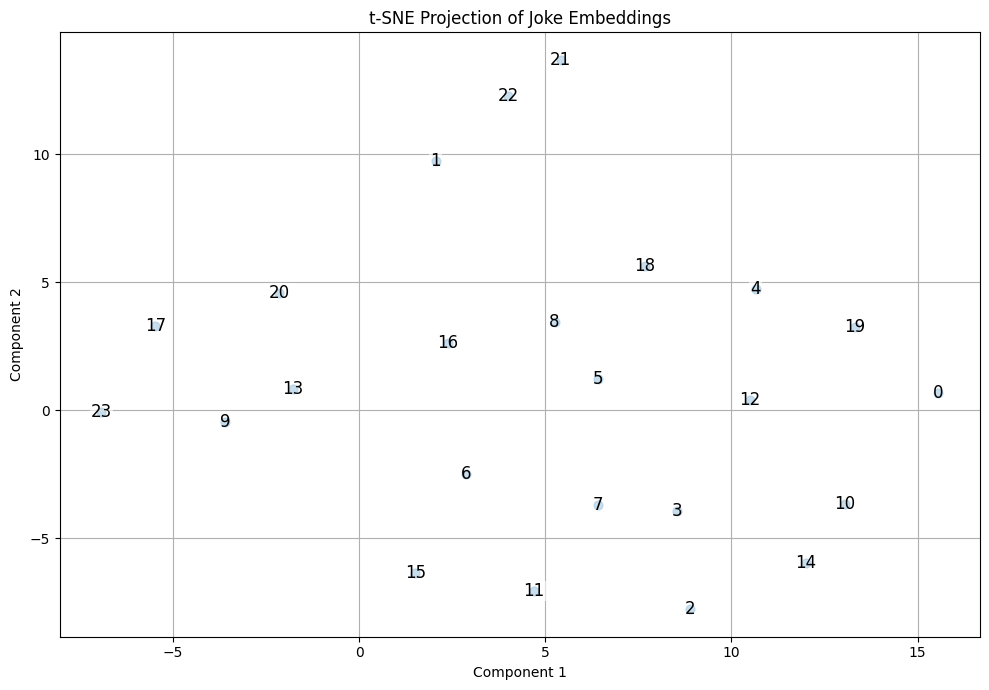

0: What kind of shoes to frogs wear? Open-toad sandals.
1: I just built an ATM that only gives out coins. I don’t know why no one’s thought of it before: it just makes cents!
2: Did I ever tell you about the time I went mushroom foraging? It’s a story with a morel at the end.
3: What happened when two slices of bread went on a date? It was loaf at first sight.
4: Why do crabs never volunteer? Because they're shell-fish.
5: I had a quiet game of tennis today. There was no racket.
6: What's a shark's favorite saying? "Man overboard!"
7: What did one slice of bread say to the other before the race? You're toast!
8: I poured some water over a duck's back yesterday. I don't think he cared.
9: I'm such a good navigator, a self-driving car once asked me for directions.
10: Why do melons have weddings? They cantelope.
11: What did the bison say to his son when he left the ranch? Bi-son.
12: Watch what you say around the egg whites. They can't take a yolk.
13: I'm so good at fixing things, my m

In [50]:
# Stack the list of embedding vectors into a 2D NumPy array
X = np.vstack(joke_embeddings)  # Shape: (n_jokes, embedding_dim)

# Initialize t-SNE with desired parameters
tsne = TSNE(n_components=2, perplexity=10, init='random', random_state=42)

# Fit and transform the embeddings to 2D
XY = tsne.fit_transform(X)

# Create a scatter plot of the 2D embeddings
plt.figure(figsize=(10, 7))
plt.scatter(XY[:, 0], XY[:, 1], s=40, alpha=0.6)

# Annotate each point with its index for clarity
for idx, (x, y) in enumerate(XY):
    plt.text(
        x, y, str(idx),
        fontsize=12,
        ha='center', va='center',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1)
    )

# Add plot titles and labels
plt.title('t-SNE Projection of Joke Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the list of jokes with their corresponding indices
for i, joke in enumerate(jokes):
    print(f"{i}: {joke}")